<a href="https://colab.research.google.com/github/pmleinan/Image-recreation-using-Fourier-feature-mapping-with-neural-network/blob/main/Regenerating_image_with_fourier_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is made on the basis of this work https://bmild.github.io/fourfeat/. It has been modefied to fit the purpus of our task.
Per Martin Leinan
NTNU 2024


In [1]:
!pip install ipdb # Debugging library
import ipdb # Debugging library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.3 MB/s eta 0:00:00


In [2]:
# imports
import imageio.v2  # used to read .jpg image data
import matplotlib.pyplot as plt
import numpy as np
import jax # jax is a library made by Google for high performance numerical calulation. Especially for machine learning.
import jax.numpy as jnp # is a modified numpy for jax
from jax import jit # just in time compilation. Uses XLA compiler to optimize machine learning code to improve speed.
from jax import random # random generator optimazed for jax
from jax import grad # jax function used for automatic differentiation
from tqdm.notebook import tqdm # Progress bar
from jax.example_libraries import stax, optimizers # stax is a neural network library to build deep learning models.
 # optimizers is a collection of optimization algorithms used for traning ML modles
from PIL import Image # library for image manipulation

In [3]:
# Loading a simple image format for testing.
# Image needs to be uploaded to the colab file repo. If other file used change the input string in the imread() function
orig_img = imageio.v2.imread('/content/heic0311a.jpg') # Loading .jpg image and normalizing it.

# Displaying some information about the image
print('Min and max values in the original image file. Min value: ' + str(np.min(orig_img)) + ' Max value: ' + str(np.max(orig_img)))
np.info(orig_img)

# Changing the size of the image to fit the ML model. This model is made for 256*256 images.
# OBS! When making the traning dataset only every second pixel is sampled.
# Therefore the size of the image after cropping needs to be twice as big and the r value 256
# This is done by finding the sentre of the image and then taking a 256*256 box around this centre.
c = [orig_img.shape[0]//2, orig_img.shape[1]//2] # Finding middle of image (and hope that the interesting part is in the middle)

# Change this value to change the size of the input image
imageDimention = 256 # Defining the dimentions of the image. 256 is set at the standard

img = orig_img[c[0]-imageDimention:c[0]+imageDimention, c[1]-imageDimention:c[1]+imageDimention] # Cropping the image to the desired dimentions
# Normalizing the pixel values between 0 and 1
img = img - np.min(img)  # Shift to minimum 0
img = img / np.max(img)  # Scale to maximum 1

# Check if the image has the right dimention
if img.ndim < 3:
  img_dimention = img.shape # Saving the dimentions of the image
  img = img.reshape((img_dimention[0], img_dimention[1], 1))
  print(np.info(img))

print(img.ndim)
# Displaying information about the croppet and normalized image
print()
print('Min and max values after normalizing the image. Min value: ' + str(np.min(img)) + ' Max value: ' + str(np.max(img)))
np.info(img)

# Diaplaying the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(orig_img)  # Use cmap='gray' for grayscale
axes[0].set_title('Original image')
axes[0].axis()

# Display the ajusted image
axes[1].imshow(img)  # Use cmap='gray' for grayscale
axes[1].set_title('Cropped and ajusted image')
axes[1].axis()

plt.tight_layout()
plt.show()

FileNotFoundError: No such file: '/content/heic0311a.jpg'

In [4]:
# Atronomical images is often in the FITS image format. To use this type of files I use the astropy library
!pip install astropy
from astropy.io import fits # library to handle FITS formats

In [5]:
# Get data from FITS file
# The FITS data format consists of a header part and one or more images.
# The header has information about the content of the file, and it contains information about
# details about the image. Time of image, adjustments of camera, exposure time and so on.
# It can contain a huge amount of technical information about the image.
# File needs to be downloaded to colab, and path in fits.open() updatet with file name.
hdul = fits.open('/content/galaxy_image.fits') # Opens the file so data can be extracted.

# To get a overview of the information in the file one can use the .info() function.
# It returmns a summery of the information in the file and where the different information is.
print(hdul.info())
# Eksample of info() output.
#Filename: /content/galaxy_image.fits
# No.    Name      Ver    Type      Cards   Dimensions   Format
#  0  PRIMARY       1 PrimaryHDU     304   ()
#  1  SCI           1 ImageHDU       110   (800, 800)   float32
#  2  WHT           1 ImageHDU       130   (800, 800)   float32
#  3  CTX           1 ImageHDU       129   (800, 800)   int32
# First (0) is the header info and additional info. 1, 2 and 3 are images.
# They are of the same object but have different atributes. Might be that one is in visual spectrum
# and other in infrared and so on.



# Access the header information. This is done by using the first data in file. "Primary"
header = hdul[0].header # Header function retives the header informaion, this is all the information in the header part of the file.
print(header) # Printing the header info.



Filename: /content/galaxy_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     304   ()      
  1  SCI           1 ImageHDU       110   (800, 800)   float32   
  2  WHT           1 ImageHDU       130   (800, 800)   float32   
  3  CTX           1 ImageHDU       129   (800, 800)   int32   
None
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  DATE    = '2009-11-04'         / date this file was written (yyyy-mm-dd)        FILETYPE= 'SCI      '          / type of data found in data file                                                                                                TELESCOP= 'HST'                / telescope used to acquire data                 INSTRUME=

In [6]:
# Choose the image file partition that you want. See printout over for information on
# images in the FITS file.
imagePartition = hdul[1] # Change index if other images are needed

# To retive the image or data in the other parts of the file one can use the .data function
data = imagePartition.data # Change index if other images are needed
# Some detailed information about the data. This will show if it tis a color or grayscale image.
print(np.info(data))

hdul.close() # Closing the file when done retreaving data.

class:  ndarray
shape:  (800, 800)
strides:  (3200, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ee9f66d9240
byteorder:  big
byteswap:  True
type: >f4
None


Min and max values in the original image file. Min value: -5.858181 Max value: 402.69672
Min and max values in the crooped image file. Min value: -0.85334134 Max value: 64.34421


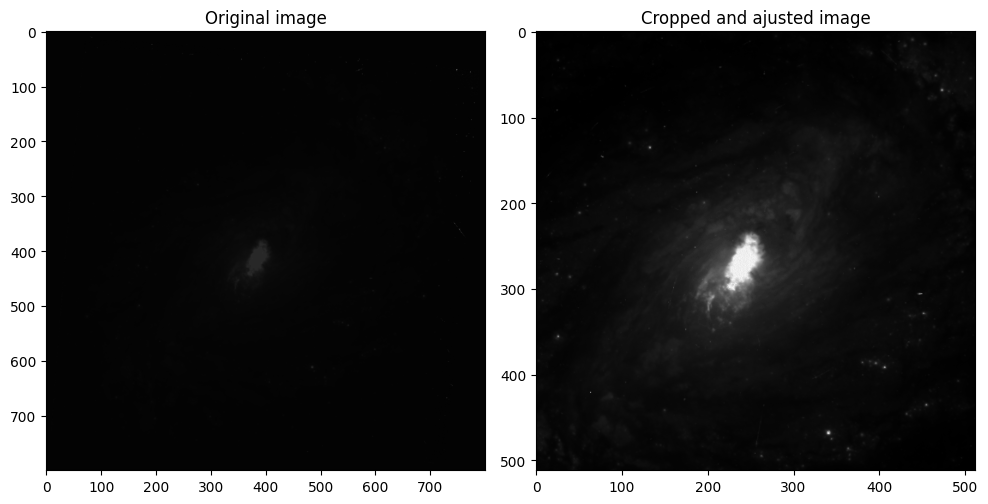

Min and max values in the adjusted image file. Min value: 0.0 Max value: 1.0
class:  ndarray
shape:  (512, 512)
strides:  (2048, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x5aac88683dd0
byteorder:  little
byteswap:  False
type: float32
None
Dimention of image to small
class:  ndarray
shape:  (512, 512, 1)
strides:  (2048, 4, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x5aac88683dd0
byteorder:  little
byteswap:  False
type: float32
None


In [7]:
# OBS!! When using FITS image data one need to investigate the actual range of the data. I have found several different ranges used,
# and some are color and some grayscale. This needs to be handeld before the image is devided in to training and test data.

# images in the FITS file have many different ranges. Printing the original range and array size
minFITSOriginal = np.min(data) # Finding the lowest value in the data
maxFITSOriginal = np.max(data) # Finding the highest value in the data
print('Min and max values in the original image file. Min value: ' + str(minFITSOriginal) + ' Max value: ' + str(maxFITSOriginal))

# Preparing the data for the ML model. This scales the image to the right size. Same method as used with the other image format.
c = [data.shape[0]//2, data.shape[1]//2] # Finding middle of image (and hope that the interesting part is in the middle)

# Change this value to change the size of the input image
imageDimention = 256 # Defining the dimentions of the image. 256 is set at the standard

FITSimg = data[c[0]-imageDimention:c[0]+imageDimention, c[1]-imageDimention:c[1]+imageDimention] # Cropping the image to the desired dimentions

# data range after cropping the data. This info is used to adjust the range of the image.
minFITS = np.min(FITSimg)
maxFITS = np.max(FITSimg)
print('Min and max values in the crooped image file. Min value: ' + str(minFITS) + ' Max value: ' + str(maxFITS))

# Normalizing the pixel values between 0 and 1
FITSimg = FITSimg - np.min(FITSimg)  # Shift to minimum 0
FITSimg = FITSimg / np.max(FITSimg)  # Scale to maximum 1

# Create subplots to compare the original image with the adjustet image for the ML model
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original FITS image
axes[0].imshow(data, cmap='gray')  # Use cmap='gray' for grayscale
axes[0].set_title('Original image')
axes[0].axis()

# Display the ajusted FITS image
axes[1].imshow(FITSimg, cmap='gray')  # Use cmap='gray' for grayscale
axes[1].set_title('Cropped and ajusted image')
axes[1].axis()

plt.tight_layout()
plt.show()

# Calculating the min and max again to verify that values are in range.
minFITSFinal = np.min(FITSimg)
maxFITSFinal = np.max(FITSimg)
print('Min and max values in the adjusted image file. Min value: ' + str(minFITSFinal) + ' Max value: ' + str(maxFITSFinal))
print(np.info(FITSimg)) # Display the final indormation about the image

# Check if the image has the right dimention
if FITSimg.ndim < 3:
  print('Dimention of image to small')
  img_dimention = FITSimg.shape # Saving the dimentions of the image
  FITSimg = FITSimg.reshape((img_dimention[0], img_dimention[0], 1))
  print(np.info(FITSimg)) # Display the final indormation about the image

In [8]:
# This code can take different image files. Because the preprocess is diffenet we need to make sure that the rigt image is sendt to the ML model.
# Choose the line under to the type of file used. img for .jpg and other standard formats and FITSimg for FITS image formats.
ml_image = FITSimg  # uncomment this line if FITS format is used.
#ml_image = img     # uncomment this line if other file formats is used.
  # only one line uncommented at a time.
if ml_image.shape[0] == ml_image.shape[1]:
  print('Image ok')
else:
  print('Wrong image format. Image needs to be a square.')

Image ok


In [9]:
# Making a coordinate system the same size as the image. Then combining it with the image.
# Every pixel position gest a x and y coordinate.
# Making an array the same length as the image and assigning
# an increasing value between 0 and 1 to them
coords = np.linspace(0, 1, ml_image.shape[0], endpoint=False)
# Creating a two dimantinal grid from the coords.
# They represent the x and y values of the pixels.
x_test = np.stack(np.meshgrid(coords, coords), -1)
# Creating the training and test datasets'
# Test data is the entire image with the coordinates.
test_data = [x_test, ml_image]
# np.info(test_data)
# Training data is every other pixel of the image and coordinate system.
#train_data = [x_test, ml_image]
train_data = [x_test[::2, ::2], ml_image[::2, ::2]]
# Representing the training data
np.info(train_data[0])

class:  ndarray
shape:  (256, 256, 2)
strides:  (16384, 32, 8)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x5aac89749780
byteorder:  little
byteswap:  False
type: float64


In [10]:
# Fourier feature mapping. The function that do the fourier mapping. This part was suggested by colap AI Gemini.
# This function takes x that is the training dataset and B that is a matrix with
# random frequencis.
def feature_mapping(x, B):
  if B is None: # Check if fourier is to be used
    return x # Returns the train data unchanged if B is None
  else:
    #print('Info about x: ' + str(x.shape))
    #print('Info about B: ' + str(B.shape))
    # The function
    # It first scales x by 2pi, then matrix multiplication with
    # the transposed B matrix.
    x_proj = (2.*jnp.pi*x) @ B.T # Had to change to jnp from np because of the use of JAX in the later code
    #print('x_proj')
    #print(x_proj.shape)
    #print(x_proj[0,0,0])
    # The data is then passed through sine and cosine functions, and the result are
    # concategated along the last axis. Then it returns the final fourier feature mapping.
    FMreturn = jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)
    #print('FMreturn')
    #print(FMreturn.shape)
    return FMreturn

In [11]:
# Defining the model architecture using the JAX package.
def make_model(num_layers, num_channels):
    layers = []

    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(1))
    layers.append(stax.Sigmoid)
    # stax.serial is a function in the jax library to create a sequention model
    # by chaining together a series of layers. The layers variable contains all the
    # the individual layers that has been defined in the model. The asterisk * unpack
    # all the elements in the layers list.
    return stax.serial(*layers)

In [12]:

# The ml model. This uses the JAX library.
# arguments: network_size gives the number of layers and number of channels of the model
# learning_rate sets the learning rate of the system
# iters sets how many iterations to train for each epoc
# B is the Fourier frequensis matrix
# Train_data contains the training data
# Test_data contains the test data
def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    #ipdb.set_trace()
    # Call to the function to set up the model structure
    init_fn, apply_fn = make_model(*network_size)

    # The jit (just in time compilation) is a jax funtion to optimize code execution
    # It compiles the code in to efficient machine code to improve speed.
    # The model_pred function takes the model parameters as input together with the input data
    # then calls the Fourier feature mapping function and feeds it through the neural
    # network to make a predicition
    model_pred = jit(lambda params, x: apply_fn(params, feature_mapping(x, B)))
    def model_prediction(params, train_data, apply_fn, B):
      feat_map = feature_mapping(train_data, B)
      temp = apply_fn(params, feat_map)
      pred = jit(temp)
      return pred

    # model_loss calculates the loss of the machine learning model
    model_loss = jit(lambda params, x, y: .5 * jnp.mean((model_pred(params, x) - y) ** 2))
    # Calculates the Signal to noise ratio (PSNR) for the models prediction
    model_psnr = jit(lambda params, x, y: -10 * jnp.log10(jnp.array(2.*model_loss(params, x, y))))
    # Calculates the gradient of the loss function. It computes how much the
    # loss would change if the weights and biases change.
    model_grad_loss = jit(lambda params, x, y: grad(model_loss)(params, x, y))

# Sets up the Adam optimizer, same type as in paper
    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_update = jit(opt_update)

    # Initializes the weights and biases of the model with random parameters and configures
    # it to accept input with a specific shape. The shape is given by the feature mapping and training data.
    _, params = init_fn(rand_key, (-1, feature_mapping(train_data[0], B).shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = [] # holds training signal to noise ratio
    test_psnrs = [] # holds test signal to noise ratio
    pred_imgs = [] # Holds the predicted images
    xs = [] # Holds a array of numbers used to plot the train and test error

    # tqdm this is a library to make progress bars
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        #test = feature_mapping(train_data[0], B)
        #test = test[250,250,:]
        #plt.plot(test)
        #plt.show()
        # For every 25 iteration it takes a sample of the training and test psnr
        # and a predicted image.
        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)
    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }

In [13]:
# Hyperparameters to define how the model is going to look.
network_size = (3, 256) # Number of layers and number of chanels per layer
learning_rate = 1e-4 # Learning rate for the optimizer
iters = 1000 # Number of training iterations
rand_key = random.PRNGKey(0) # Random value used to initialice the model

mapping_size = 256 # Number of fourier features

# Sets up the Fourier feature mapping
# Can create multiple B matrixes to test several different sigma values in one run.
B_dict = {} # holds all the B matrixes
# Standard network - no mapping
B_dict['none'] = None
# The different scales of Gaussian Fourier feature mappings.
# Generate a matrix of random numbers from a Gaussian distribution
# Hva er 2 i linja under
B_gauss = random.normal(rand_key, (mapping_size, 2))
# Scale the random matrix with a sigma value. It will calculate one
# output for each sigma value chosen.
for scale in [5.,10., 20.]:
  # Scaling of matrix and add to list.
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# calls the model to start training the model
outputs = {} # holder for the outputs
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/4 [00:00<?, ?it/s]

train iter:   0%|          | 0/1000 [00:00<?, ?it/s]

(256, 256, 512)


train iter:   0%|          | 0/1000 [00:00<?, ?it/s]

(256, 256, 512)
(512, 512, 512)
(256, 256, 512)


train iter:   0%|          | 0/1000 [00:00<?, ?it/s]

(256, 256, 512)
(512, 512, 512)
(256, 256, 512)


train iter:   0%|          | 0/1000 [00:00<?, ?it/s]

(256, 256, 512)
(512, 512, 512)


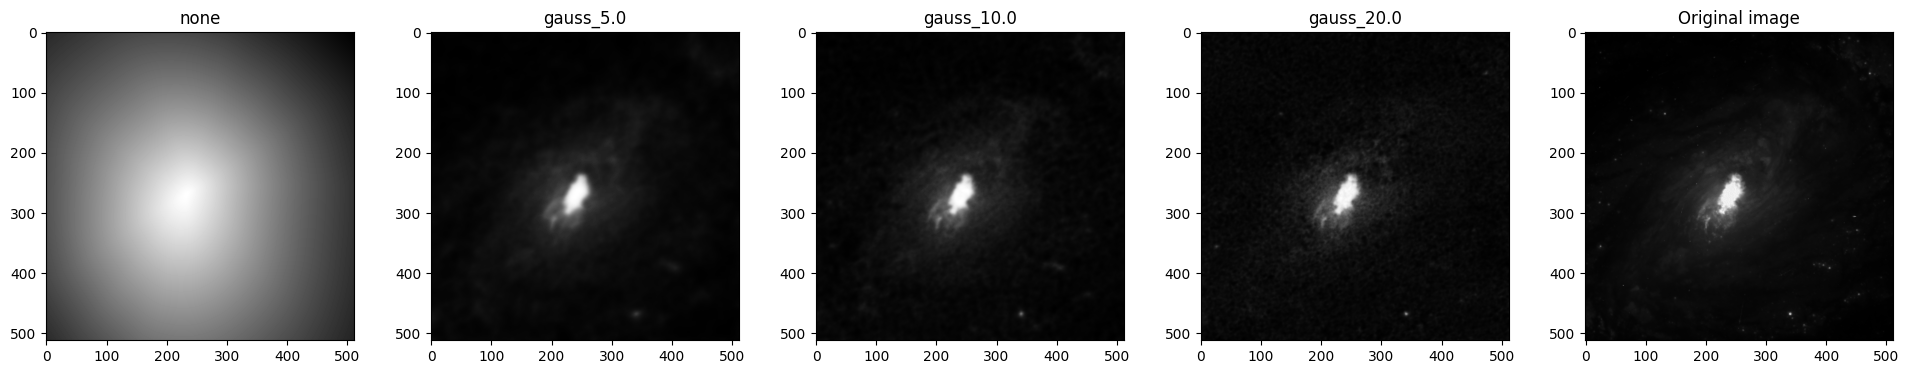

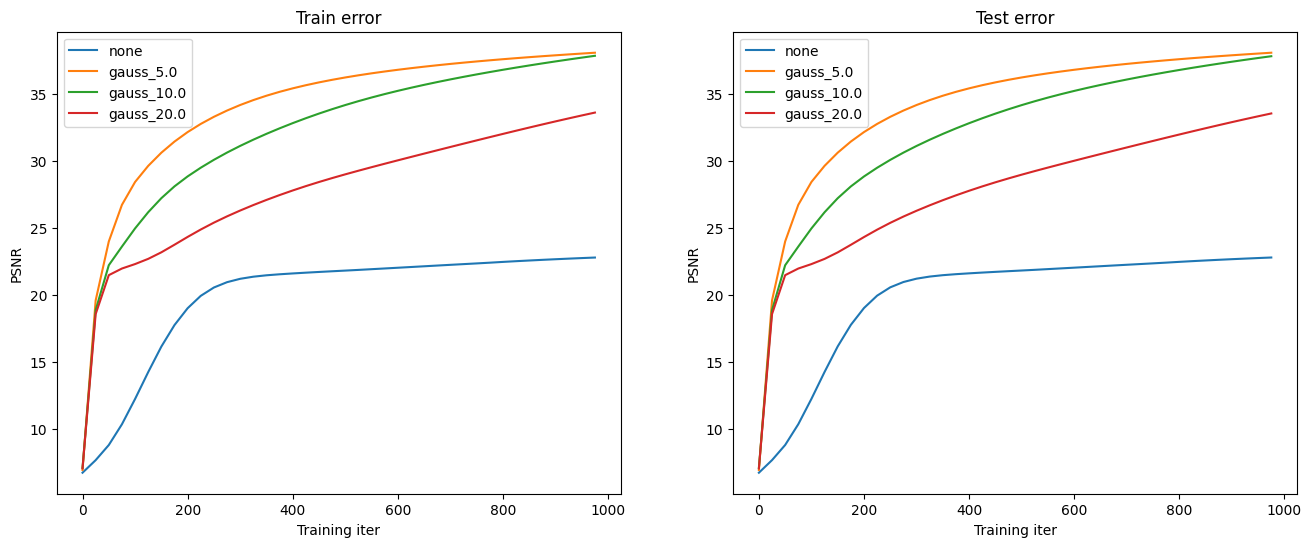

In [14]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1], cmap='gray')
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(ml_image, cmap='gray')
plt.title('Original image')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()